# Self Test 2
## 2.1 - Fitting a self organizing map to in-game data

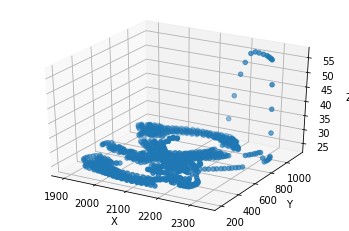

In [47]:
import numpy as np
import networkx as nx
import numpy.random as rnd
import string
import matplotlib.pyplot as plt
from matplotlib import cm

matX = np.genfromtxt('../data/q3dm1-path2.csv',delimiter=',')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1],matX[:,0],matX[:,2], marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [48]:
def initRingSOM(matX, k, start=1):
    G = nx.generators.lattice.grid_2d_graph(k, start, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(m, k, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[smpl[i],:]
    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a row of matrix X
        vecX = matX[smpl[t],:]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
    return G

In [61]:
G1 = initRingSOM(matX, 12)
G2 = initRingSOM(matX, 12)
G = nx.disjoint_union(G1,G2)
G.add_edge(11, 12)

G.edges()

EdgeView([(0, 1), (0, 11), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (12, 13), (12, 23), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23)])

In [62]:
SOM1 = trainSOM(matX, G, tmax=10000)

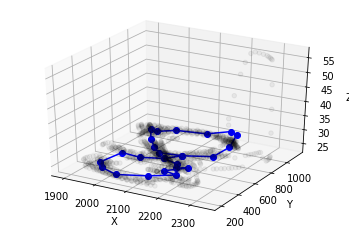

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1],matX[:,0],matX[:,2], color='black' ,marker='o',alpha=0.05)

neurons = []

# Connect 
neurons.append(SOM1.nodes[11]['w'])

for i in range(len(SOM1.nodes())):
    neurons.append(SOM1.nodes[i]['w'])

neurons.append(SOM1.nodes[12]['w'])
neurons = np.array(neurons)

ax.plot(neurons[:,1],neurons[:,0],neurons[:,2],'b-o')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.savefig('Figures/som24.png', bbox_inches='tight')
plt.show()

In [60]:
def get_dist(x1, x2):
    return np.sum((x1-x2)**2)**0.5

def compute_mse(matX, G):
    dists = []
    for x in matX:
        small_dist = np.inf
        # loop for every node
        for i in range(len(G.nodes())):
            # compute distance
            dist = get_dist(x,G.nodes[i]['w'])
            # save smallest distance
            if dist < small_dist:
                small_dist = dist
            
        dists.append(small_dist)
    dists = np.array(dists)
    mse = sum(dists**2) / len(dists)
    return mse

In [14]:
mse = compute_mse(matX, G)
round(mse, 2)

1671.85

## 2.2 - Action primitives from in-game data

In [28]:
def get_velocities(matX):
    velocities = []

    for i in range(1, matX.shape[0]):
        vel = matX[i] - matX[i-1]
        velocities.append(vel)
    return np.array(velocities)

def compute_avg_vel(velocities):
    return velocities.sum(axis=0) / velocities.shape[0]

In [44]:
vels = get_velocities(matX)
avg = compute_avg_vel(vels)
avg.round(4)

array([-0.338 ,  0.1112,  0.    ])

In [33]:
import scipy.cluster.vq as vq

matA, inds = vq.kmeans2(matX, k=24, iter=100, minit='++')

In [45]:
vels = get_velocities(matA)
avg = compute_avg_vel(vels)
avg.round(4)

array([-7.8100e-02, -5.9163e+00, -4.0000e-04])